# Распознавание эмоций с помощью модели VALENCE-AROUSAL

**В модели Дж. Рассела водится двумерный базис, в котором каждая эмоция характеризуется знаком (valence) и интенсивностью (arousal). Ввиду своей простоты модель Рассела в последнее время приобретает все большую популярность в контексте задачи автоматической классификации выражения лица.**

**Чтобы обучить модель распознавать эмоции с помощью разложения на valence и arousal, нужен большой размеченный датасет. Они существуют, но доступ к ним для меня как просто физического лица закрыт. Я связывался с различными в основном американскими институтами, обладающими такими обучающими базами. И они отвечали. Но у всех требование, чтобы запрос на такую базу исходил от какого либо НИИ с обоснованием ее необходимости. И тогда они готовы были предоставить ее бесплатно.**

**Что ж. Будем выходить из ситуации экспериментальным путем.**

**Загрузим необходимые библиотеки.**

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from livelossplot.tf_keras import PlotLossesCallback
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
import time
import numpy as np
from PIL import Image
import tensorflow_addons as tfa
from random import random, seed
import math
from scipy.spatial import distance

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
# !pip install livelossplot
# !pip install tensorflow-addons

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/Скиллбокс/Нейронные сети/Дипломная работа

**Возьмем популярную в сети схему расположения эмоций на единичной окружности.**

![valence-arousal.jpg](attachment:valence-arousal.jpg)

**Итак, нам даны 8 эмоций и папка uncertain, содержащая все не попадающие в эту восьмерку. Находим их на этой схеме, проводим из центра окружности лучи, проходящие через них и записываем координаты пересечения этих лучей с окружностью в словарь coords. Будем считать, что точка пересечения луча и окружности будет соответствовать максимальной соответствующей эмоции, а чем ближе спускаться по лучу к центру, тем эмоция будет становиться слабее. Для нейтральной эмоции максимум будет находится в центре окружности. То есть если идти по лучу любой эмоции к центру, то эмоция постепенно ослабевает, превращаясь в центре в абсолютно нейтральную. Визуализируем наши лучи.**

In [6]:
# Координаты эмоции на единичной окружности
coords = {'anger': [-0.46, 0.89],
         'contempt': [-0.65, 0.76],
         'disgust': [-0.81, 0.58],
         'fear': [-0.14, 0.99],
         'happy': [0.98, 0.19],
         'neutral': [0, 0],
         'sad': [-0.9, -0.44],
         'surprise': [0.43, 0.90]}

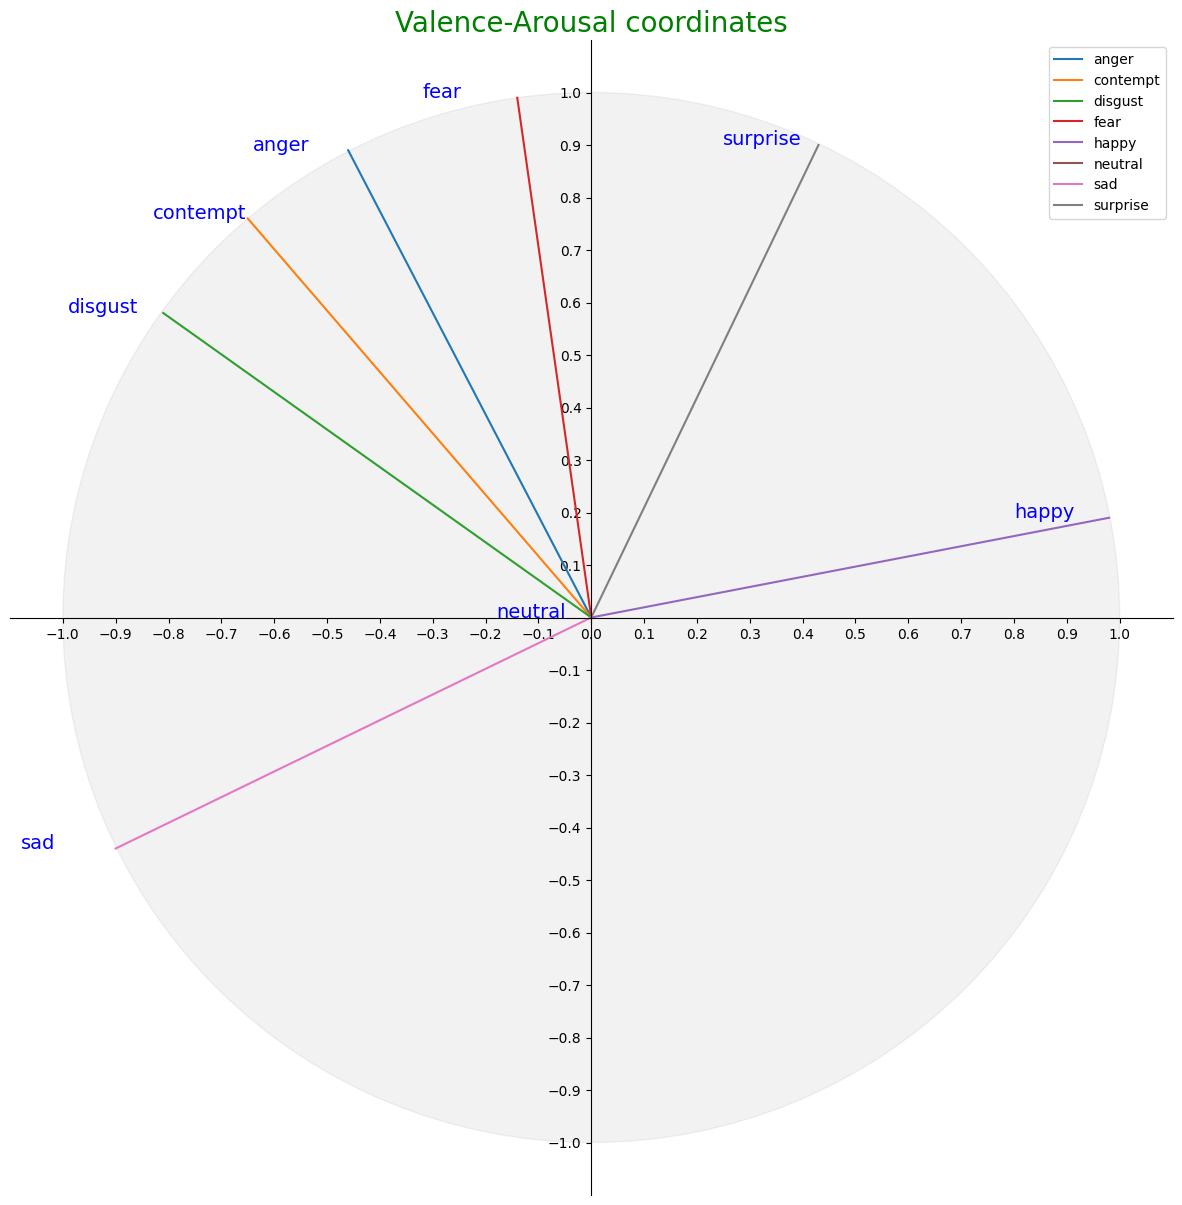

In [ ]:
# fig, ax = plt.subplots(figsize=(15, 15))
# ax.set_xlim([-1.1, 1.1])
# ax.set_ylim([-1.1, 1.1])
# ax.spines['left'].set_position('zero')
# ax.spines['bottom'].set_position('zero')
# ax.spines['right'].set_color('none')
# ax.spines['top'].set_color('none')
# ax.set_xticks(np.arange(-1, 1.1, 0.1))
# ax.set_yticks([i for i in np.arange(-1, 1.1, 0.1) if i > 0.05 or i < -0.05])
# ax.set_title('Valence-Arousal coordinates', color = 'g', fontsize = 20)
# circle = plt.Circle((0, 0), 1, color = 'grey', alpha = 0.1)
# ax.add_patch(circle)
# for key in coords:
#     ax.plot([0, coords[key][0]], [0, coords[key][1]], label = key)
#     ax.text(coords[key][0] - 0.18, coords[key][1], key, color = 'b', fontsize = 14)
# ax.legend()
# plt.show()

**Следующая функция генерирует случайную точку в пределах окружности с центром (x, y) и радиусом r.**

In [7]:
# случайная точка в круге
def sqrt_dist(x, y, r):
    theta = random() * 2 * np.pi
    r = np.sqrt(random()) * r
    return x + r * np.cos(theta), y + r * np.sin(theta)

**Итак, как я уже говорил, доступа к реально размеченным на valence и arousal датасетам у меня нет. Поэтому используем наш датасет. Идея следующая - если эмоция нейтральная, то рандомно генерируем ее va-координаты в пределах окружности с центром в начале координат и радиусом 0.1. Соответственно все эмоции, реальная вероятность которых менее 0.1 будем считать нейтральными, так как все лучи эмоций сходятся в точке (0, 0). Далее берем какую то не нейтральную эмоцию, смотрим ее вероятность и эта вероятность будет определять положение точки на луче эмоции - если 1, то это сама единичная окружность и максимальная по силе эмоция, если 0.5 - середина луча и т.д. Теперь генерируем рандомные va-координаты для этой эмоции в пределах окружности радиуса 0.1 с центром в точке на луче эмоции, соответствующей ее на нем положению. Лучи некоторых эмоций находятся близко друг к другу, поэтому при генерации va-координать может получиться, что точка сгенерируется ближе к лучу соседней эмоции и тогда ее брать нельзя. Соответственно учтем это - после генерации точки проверяем ее расстояние по перпендикуляру до луча эмоции и до луча соседней эмоции. Если расстояние до соседнего луча меньше, то не берем эту точку и генерируем следующую. Все это прописываем в следующей функции.**

In [8]:
def generate_valence_arousal(emo_percent):
    emo, percent = emo_percent.split('_')
    percent = float(percent)
    if emo == 'neutral':
        valence, arousal = sqrt_dist(0, 0, 0.1)
    else:
        while True:
            x, y = coords[emo][0] * percent, coords[emo][1] * percent
            valence, arousal = sqrt_dist(x, y, 0.1)
            p1 = np.array([valence, arousal])
            p2 = np.array([0, 0])
            p3 = np.array(coords[emo])
            dist = np.abs(np.cross(p2-p1,p3-p1)/np.linalg.norm(p2-p3))
            coords_short = coords.copy()
            del coords_short[emo]
            del coords_short['neutral']
            flag = False
            for emotion in coords_short:
                p3 = np.array(coords[emotion])
                if np.abs(np.cross(p2-p1,p3-p1)/np.linalg.norm(p2-p3)) < dist\
                or distance.euclidean([0 ,0], [valence, arousal]) <= 0.1\
                or distance.euclidean([0 ,0], [valence, arousal]) > 1:
                    flag = True
            if not flag:
                break
    return (valence, arousal)

In [ ]:
# with open("df.txt", "rb") as myFile:
#     df = pd.read_pickle(myFile)

**Функция для перевода эмоций с вероятностью менее 0.1 в нейтральные.**

In [9]:
def to_neutral(x):
    if x[4] <= 0.1:
        x[1] = 'neutral'
    return x

**Для эмоций из папки UNCERTAIN невозможно сгенерировать va-координаты, поэтому исключаем их из датасета. В дальнейшем при предсказании будем скидывать в uncertain все эмоции, предсказанные координаты которых не будут лежать в пределах 0.1 от лучей эмоций.**

In [ ]:
# df = df[df['emotion'] != 'uncertain']
# df = df.apply(lambda x: to_neutral(x), axis = 1)
# df

,image_path,emotion,predict_emotion,predict_percent,real_percent
0,./train/anger/0.jpg,anger,fear,0.642120,0.341115
1,./train/anger/1.jpg,neutral,neutral,0.931658,0.014904
2,./train/anger/10.jpg,anger,anger,0.610033,0.610033
3,./train/anger/100.jpg,anger,anger,0.489100,0.489100
4,./train/anger/1000.jpg,anger,neutral,0.574323,0.153754
...,...,...,...,...,...
44114,./train/surprise/995.jpg,surprise,surprise,0.541102,0.541102
44115,./train/surprise/996.jpg,surprise,surprise,0.458567,0.458567
44116,./train/surprise/997.jpg,surprise,neutral,0.632982,0.167642
44117,./train/surprise/998.jpg,surprise,surprise,0.615156,0.615156


In [ ]:
# df['emotion_percent'] = df['emotion'] + '_' + df['real_percent'].astype('string')
# df

,image_path,emotion,predict_emotion,predict_percent,real_percent,emotion_percent
0,./train/anger/0.jpg,anger,fear,0.642120,0.341115,anger_0.34111520648002625
1,./train/anger/1.jpg,neutral,neutral,0.931658,0.014904,neutral_0.014904296025633812
2,./train/anger/10.jpg,anger,anger,0.610033,0.610033,anger_0.6100327372550964
3,./train/anger/100.jpg,anger,anger,0.489100,0.489100,anger_0.4890997111797333
4,./train/anger/1000.jpg,anger,neutral,0.574323,0.153754,anger_0.15375356376171112
...,...,...,...,...,...,...
44114,./train/surprise/995.jpg,surprise,surprise,0.541102,0.541102,surprise_0.5411021113395691
44115,./train/surprise/996.jpg,surprise,surprise,0.458567,0.458567,surprise_0.45856717228889465
44116,./train/surprise/997.jpg,surprise,neutral,0.632982,0.167642,surprise_0.16764169931411743
44117,./train/surprise/998.jpg,surprise,surprise,0.615156,0.615156,surprise_0.6151561141014099


**Получаем следующий датафрейм со сгенерированными va-координатами.**

In [ ]:
# df['va_coords'] = df['emotion_percent'].apply(generate_valence_arousal)
# df['valence'] = df['va_coords'].apply(lambda x: x[0])
# df['arousal'] = df['va_coords'].apply(lambda x: x[1])
# df_va = df.loc[:, ['image_path', 'emotion', 'valence', 'arousal']]
# df_va

,image_path,emotion,valence,arousal
0,./train/anger/0.jpg,anger,-0.131069,0.275796
1,./train/anger/1.jpg,neutral,0.056333,0.027326
2,./train/anger/10.jpg,anger,-0.229381,0.551449
3,./train/anger/100.jpg,anger,-0.148397,0.462302
4,./train/anger/1000.jpg,anger,-0.108022,0.183317
...,...,...,...,...
44114,./train/surprise/995.jpg,surprise,0.142271,0.468459
44115,./train/surprise/996.jpg,surprise,0.233928,0.492888
44116,./train/surprise/997.jpg,surprise,0.165033,0.180157
44117,./train/surprise/998.jpg,surprise,0.261527,0.610984


**Сохраняем его во внешнем файле df_va.txt.**

In [10]:
# with open("df_va.txt", "wb") as myFile:
#     pickle.dump(df_va, myFile)
with open("df_va.txt", "rb") as myFile:
    df_va = pickle.load(myFile)

**Визуализируем все наши сгенерированные точки.**

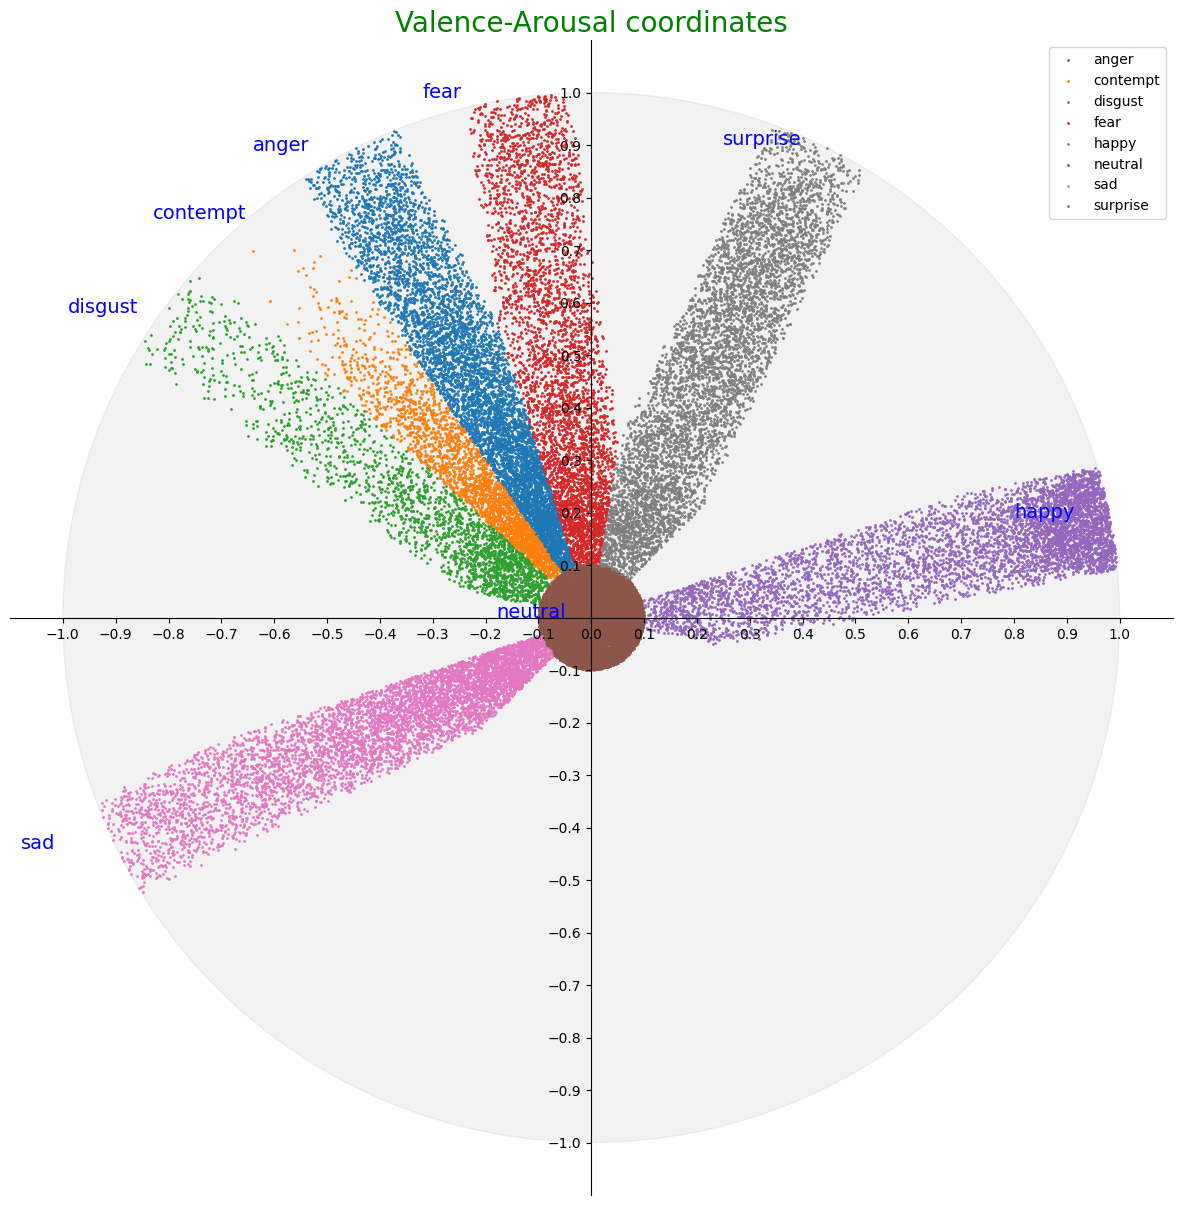

In [ ]:
# fig, ax = plt.subplots(figsize=(15, 15))
# ax.set_xlim([-1.1, 1.1])
# ax.set_ylim([-1.1, 1.1])
# ax.spines['left'].set_position('zero')
# ax.spines['bottom'].set_position('zero')
# ax.spines['right'].set_color('none')
# ax.spines['top'].set_color('none')
# ax.set_xticks(np.arange(-1, 1.1, 0.1))
# ax.set_yticks([i for i in np.arange(-1, 1.1, 0.1) if i > 0.05 or i < -0.05])
# ax.set_title('Valence-Arousal coordinates', color = 'g', fontsize = 20)
# circle = plt.Circle((0, 0), 1, color = 'grey', alpha = 0.1)
# ax.add_patch(circle)
# for key in coords:
#     ax.text(coords[key][0] - 0.18, coords[key][1], key, color = 'b', fontsize = 14)
#     x = df_va[df_va['emotion'] == key]['valence']
#     y = df_va[df_va['emotion'] == key]['arousal']
#     ax.scatter(x, y, s = 1, label = key)
# ax.legend()
# plt.show()

**Можно приступать к обучению сети.**

In [11]:
train_df = df_va.groupby('emotion', group_keys= False).apply(lambda x: x. sample (frac = 0.8, random_state=17))
val_df = df_va.drop(train_df.index)

In [12]:
photos_list = []
for i in range(5000):
    photos_list.append(os.path.join(os.getcwd(), 'test_kaggle', str(i) + '.jpg'))
test_df = pd.DataFrame(photos_list, columns = ['image_path'])
test_df.head()

,image_path
0,/content/drive/MyDrive/Скиллбокс/Нейронные сет...
1,/content/drive/MyDrive/Скиллбокс/Нейронные сет...
2,/content/drive/MyDrive/Скиллбокс/Нейронные сет...
3,/content/drive/MyDrive/Скиллбокс/Нейронные сет...
4,/content/drive/MyDrive/Скиллбокс/Нейронные сет...


In [13]:
names = {0: "anger", 1: "contempt", 2: "disgust", 3: "fear",
             4: "happy", 5: "neutral", 6: "sad", 7: "surprise", 8: "uncertain"}

**В генератор передаем class_mode = raw, так как мы будем предсказывать регрессию - то есть координаты не принимают дискретных значений, это величина непрерывная.**

In [14]:
def make_data_generator_va(generator_type, df, img_size, batch_size, resc = None, prep = None):
    if generator_type == 'train':
        train_generator = ImageDataGenerator(rescale=resc,
                                     preprocessing_function=prep,
                                     rotation_range=45,
                                     horizontal_flip=True,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     channel_shift_range=50,
                                     fill_mode='nearest',
                                     brightness_range=[0.2,1.5])
        data_gen = train_generator.flow_from_dataframe(dataframe=df,
                                                     x_col='image_path',
                                                     y_col=['valence','arousal'],
                                                     target_size=(img_size, img_size),
                                                     batch_size=batch_size,
                                                     class_mode='raw',
                                                     shuffle=True)
    if generator_type == 'val':
        val_generator = ImageDataGenerator(rescale=resc,
                                          preprocessing_function=prep)
        data_gen = val_generator.flow_from_dataframe(dataframe=df,
                                                 x_col='image_path',
                                                 y_col=['valence','arousal'],
                                                 target_size=(img_size, img_size),
                                                 batch_size=batch_size,
                                                 class_mode='raw',
                                                 shuffle=False)
    return data_gen

In [23]:
def one_emotion_predict(model, path, img_size, norm = False):
    names = {0: "anger", 1: "contempt", 2: "disgust", 3: "fear",
             4: "happy", 5: "neutral", 6: "sad", 7: "surprise", 8: "uncertain"}
    names_reverse = {v : str(k) for k, v in names.items()}
    test_img = Image.open(path)
    test_img = test_img.resize((img_size, img_size))
    test_img = np.array(test_img.getdata()).reshape(test_img.size[0], test_img.size[1], 3)
    if norm:
        test_img = test_img / 255
    test_img = test_img[np.newaxis, ...]
    pred = model.predict(test_img)[0]
    if np.sqrt(pred[0] ** 2 + pred[1] ** 2) <= 0.1:
        return 5
    else:
        coords_short = coords.copy()
        del coords_short['neutral']
        emo_dist = {}
        for emotion in coords_short:
            p3 = np.array(coords[emotion])
            p1 = pred
            p2 = np.array([0, 0])
            emo_dist[emotion] = np.abs(np.cross(p2-p1,p3-p1)/np.linalg.norm(p2-p3))
        emo_dist = dict(sorted(emo_dist.items(), key=lambda item: item[1]))
        if list(emo_dist.values())[0] > 0.1 or np.sqrt(pred[0] ** 2 + pred[1] ** 2) > 1:
            return 8
        else:
            return int(names_reverse[list(emo_dist.keys())[0]])

**Число предсказываемых классов равно двум - две координаты.**

In [16]:
BATCH_SIZE = 104
IMAGE_SIZE = 224
N_CLASSES = 2

In [17]:
train_data_gen = make_data_generator_va('train', train_df, IMAGE_SIZE, BATCH_SIZE)
val_data_gen = make_data_generator_va('val', val_df, IMAGE_SIZE, BATCH_SIZE)

Found 35296 validated image filenames.
Found 8823 validated image filenames.


In [ ]:
base_model = tf.keras.applications.convnext.ConvNeXtXLarge(
    model_name='convnext_xlarge',
    include_top=False,
    include_preprocessing=True,
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3),
    classifier_activation=None
)
base_model.trainable = False

In [ ]:
va_model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(1024),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(N_CLASSES)
])

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-4,
    decay_steps=100,
    decay_rate=0.9)
checkpoint = ModelCheckpoint(os.path.join(os.getcwd(), 'CPT', 'va_model', '{epoch:02d}_checkpoint_{val_mean_squared_error:.3f}'),
                             monitor = 'val_mean_squared_error',
                             verbose=1,
                             save_best_only=True,
                             save_freq='epoch',
                             mode='min')
es = EarlyStopping(monitor='val_mean_squared_error', mode='min', verbose=1, patience=10)
va_model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              metrics=[tf.keras.metrics.MeanSquaredError()])

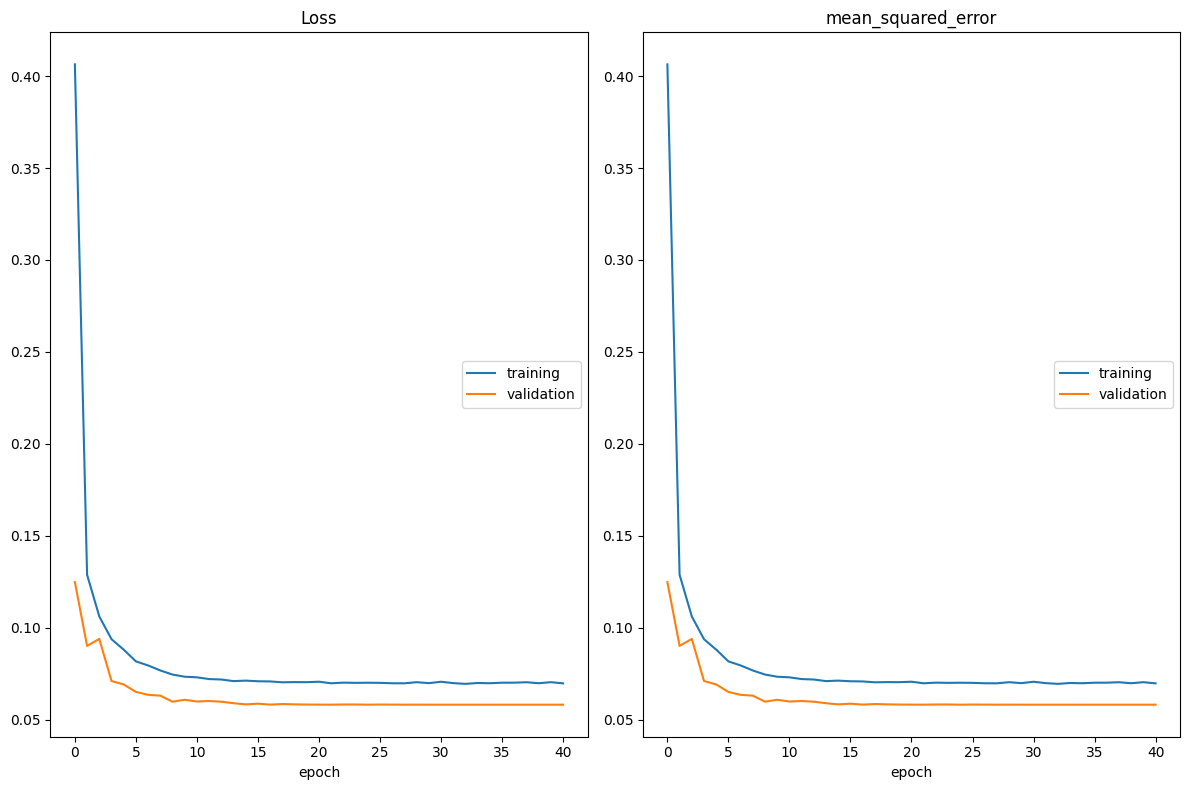

Loss
	training         	 (min:    0.069, max:    0.406, cur:    0.070)
	validation       	 (min:    0.058, max:    0.125, cur:    0.058)
mean_squared_error
	training         	 (min:    0.069, max:    0.406, cur:    0.070)
	validation       	 (min:    0.058, max:    0.125, cur:    0.058)
340/340 [==============================] - 759s 2s/step - loss: 0.0697 - mean_squared_error: 0.0697 - val_loss: 0.0581 - val_mean_squared_error: 0.0581
Epoch 41: early stopping


In [ ]:
EPOCHS = 50
history = va_model.fit(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    callbacks=[es, checkpoint, PlotLossesCallback()])

**В дальнейшем загружаем нашу модель с лучшими параметрами из чекпойнта.**

In [18]:
va_model = load_model(os.path.join(os.getcwd(),'CPT', 'va_model', '31_checkpoint_0.058'))

In [24]:
answer_df = pd.read_csv('sample_submission.csv')
answer_df['emotion'] = test_df['image_path'].apply(lambda x: one_emotion_predict(va_model, x, IMAGE_SIZE))
answer_df['emotion'] = answer_df['emotion'].apply(lambda x: names[x])

Выходные данные были обрезаны до нескольких последних строк (5000).
1/1 [==============================] - 0s 136ms/step


In [25]:
answer_df

,image_path,emotion
0,0.jpg,disgust
1,1.jpg,surprise
2,2.jpg,happy
3,3.jpg,fear
4,4.jpg,surprise
...,...,...
4995,4995.jpg,surprise
4996,4996.jpg,fear
4997,4997.jpg,sad
4998,4998.jpg,sad


In [26]:
answer_df.to_csv('answer.csv', index = False)

**Результат на private kaggle 0.196 и это ожидаемо. Слишком много предположений и рандома. Но в данном случае это неважно - главное было показать как можно создать подобную модель и реализовать ее инференс.**